In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.13.0
Keras version: 0.1.7
KerasNLP version: 0.7.0


In [4]:
import sys
import gc

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

# Load Dataset


In [5]:
DATA_DIR = '/kaggle/input/llm-detect-ai-generated-text/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [6]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [7]:
# only two prompts used in the dataset

In [8]:
df_train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [9]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

Text(0.5, 1.0, 'Distribution of prompt ID')

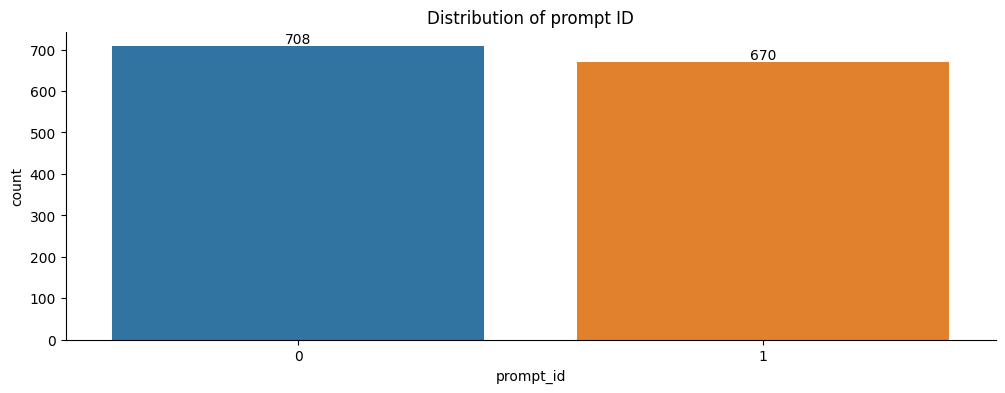

In [10]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="prompt_id")

abs_values = df_train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

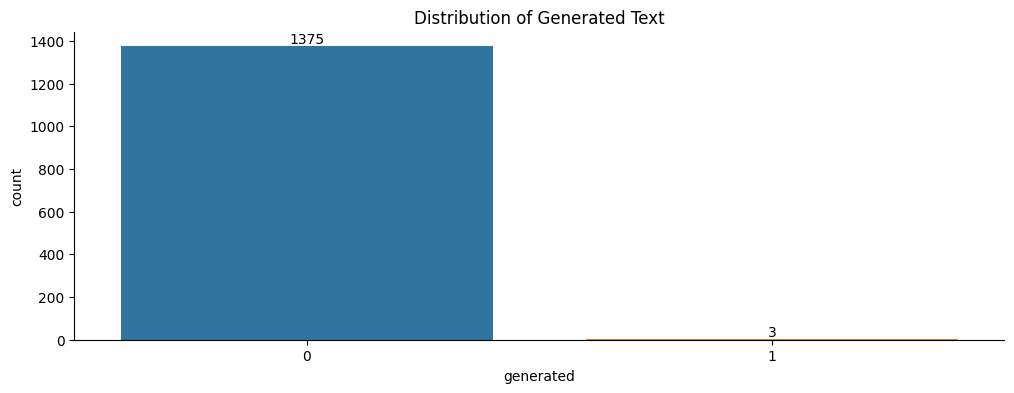

In [11]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="generated")

abs_values = df_train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [12]:
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [13]:
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [14]:
train = train.drop_duplicates(['text'])
train.reset_index(drop=True, inplace=True)

In [15]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [16]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

In [17]:
# Creating Byte-Pair Encoding tokenizer
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
dataset = Dataset.from_pandas(test[['text']])
def train_corp_iter(): 
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]
tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_test = []

for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44868 [00:00<?, ?it/s]

In [18]:
def dummy(text):
    return text
vectorizer = TfidfVectorizer(ngram_range=(3, 7), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode')

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

print(vocab)

vectorizer = TfidfVectorizer(ngram_range=(3, 7), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


23

In [19]:
y_train = train['label'].values

In [20]:
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [21]:
if len(test.text.values) <= 5:
    sub.to_csv('submission.csv', index=False)
else:
    clf = MultinomialNB(alpha=0.02)
    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
    p6={'n_iter': 2500,
        'verbose': -1,
        'objective': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.006, 
        'colsample_bytree': 0.78,
        'colsample_bynode': 0.8, 
        'lambda_l1': 4.6, 
        'lambda_l2': 3, 
        'min_data_in_leaf': 115, 
        'max_depth': 25, 
        'max_bin': 900}
    
    lgb=LGBMClassifier(**p6)
    cat=CatBoostClassifier(iterations=2000,
                           verbose=0,
                           l2_leaf_reg=7,
                           learning_rate=0.006,
                           subsample = 0.4,
                           allow_const_label=True,loss_function = 'CrossEntropy')
    weights = [0.3,0.3,0.3,0.3]
 
    ensemble = VotingClassifier(estimators=[('mnb',clf),
                                            ('sgd', sgd_model),
                                            ('lgb',lgb), 
                                            ('cat', cat)
                                           ],
                                weights=weights, voting='soft', n_jobs=-1)
    ensemble.fit(tf_train, y_train)
    gc.collect()
    final_preds = ensemble.predict_proba(tf_test)[:,1]
    sub['generated'] = final_preds
    sub.to_csv('submission.csv', index=False)
    sub